# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# Readme
The following libraries need to be installed in order to run the source code.

In [3]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings = warnings

In [4]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

# 1.Dataset Processing

Load the dataset. The following tables are loaded for this project:
- PATIENTS
- ADMISSIONS
- DIAGNOSES_ICD
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [5]:
path_patients = ROOT_DIR / 'data' / "PATIENTS.csv"  
path_admissions = ROOT_DIR / 'data' / "ADMISSIONS.csv"
path_diagnoses_icd = ROOT_DIR / 'data' / "DIAGNOSES_ICD.csv"
path_labevents = ROOT_DIR / 'data' / "LABEVENTS.csv"
path_microbiologyevents = ROOT_DIR / 'data' / "MICROBIOLOGYEVENTS.csv"
path_desc_icd = ROOT_DIR / 'data' / "D_ICD_DIAGNOSES.csv"
path_desc_labitems = ROOT_DIR / 'data' / "D_LABITEMS.csv"
path_desc_items = ROOT_DIR / 'data' /  "D_ITEMS.csv"

In [6]:
# load transaction dataset
df_patients = pd.read_csv(path_patients)
df_admissions = pd.read_csv(path_admissions)
df_diagnoses_icd = pd.read_csv(path_diagnoses_icd)
df_labevents = pd.read_csv(path_labevents)
df_microbiologyevents = pd.read_csv(path_microbiologyevents)

# load description tables
df_desc_icd = pd.read_csv(path_desc_icd)
df_desc_labitems = pd.read_csv(path_desc_labitems)
df_desc_items = pd.read_csv(path_desc_items)

## 1.1 Data Cleaning

In [7]:
# Convert the following datetime columns to datetime format
# patients: DOB to date format, we not care about the birth time
df_patients['DOB'] = pd.to_datetime(df_patients['DOB'], format='%Y-%m-%d %H:%M:%S')
# admissions: ADMITTIME, DISCHTIME, EDREGTIME, EDOUTTIME
df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')
# labevents: CHARTTIME
df_labevents['CHARTTIME'] = pd.to_datetime(df_labevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
# microbiologyevents: CHARTDATE to date format and CHARTTIME to datetime format
df_microbiologyevents['CHARTDATE'] = pd.to_datetime(df_microbiologyevents['CHARTDATE'], format='%Y-%m-%d %H:%M:%S')
df_microbiologyevents['CHARTTIME'] = pd.to_datetime(df_microbiologyevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [8]:
# retrieve all sepsis icd code
sepsis_icd =  df_desc_icd[df_desc_icd.apply(lambda x:'sepsis' in x['SHORT_TITLE'].lower(),axis=1)]['ICD9_CODE'].values
# add new binary classifier target variable
df_diagnoses_icd['IS_SEPSIS'] = df_diagnoses_icd.apply(lambda x: 1 if x['ICD9_CODE'] in sepsis_icd else 0, axis=1)

In [9]:
# create function for checking the admission diagnoses to find whether it is diagnosed sepsis
def check_sepsis(subject_id, hadm_id, df_diagnoses_icd):
    admission_diagnoses = df_diagnoses_icd[(df_diagnoses_icd['SUBJECT_ID'] == subject_id) & (df_diagnoses_icd['HADM_ID'] == hadm_id)]
    is_sepsis = 1 if sum(admission_diagnoses['IS_SEPSIS']) > 0 else 0
    return is_sepsis

In [10]:
# create demographic df and save to csv file for future load
try:
    pathname_demographic = ROOT_DIR / 'data' / 'demographic.csv'
    df_demographic = pd.read_csv(pathname_demographic)
except:
    # merge the patients and admission tables to a demographic dataframe
    df_demographic = pd.merge(df_admissions, df_patients[['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']], on='SUBJECT_ID')
    # create an age column to each case
    df_demographic['AGE'] = (((df_demographic['ADMITTIME'].dt.date - df_demographic['DOB'].dt.date) // 365) / pd.Timedelta(days=1)).astype('int16')
    # add column IS_SEPSIS to demographic data indicating which case is diagnosed with sepsis
    df_demographic['IS_SEPSIS'] = df_demographic.apply(lambda x: check_sepsis(x['SUBJECT_ID'], x['HADM_ID'], df_diagnoses_icd), axis=1)
    util.save_csv(df_demographic, ROOT_DIR / 'data' / 'demographic.csv')

# convert admittime and dischtime to datetime
df_demographic['ADMITTIME'] = pd.to_datetime(df_demographic['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_demographic['DISCHTIME'] = pd.to_datetime(df_demographic['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')

In [11]:
# create age category 
df_demographic = util.categorise_age(df_demographic)

<Axes: title={'center': 'AGE'}, xlabel='IS_SEPSIS'>

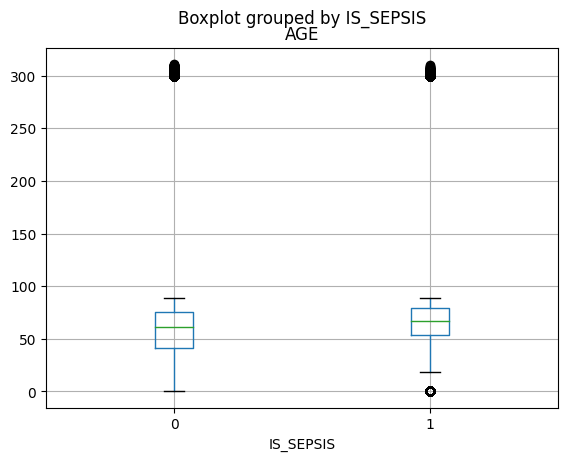

In [12]:
# plotting the age of admissions
df_demographic.boxplot(column=['AGE'], by='IS_SEPSIS')

In [13]:
count_over100 = len(df_demographic[df_demographic.AGE>100])
p_over100 = len(df_demographic[df_demographic.AGE>100])/len(df_demographic)*100
median_age = int(df_demographic['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of patients: {}'.format(median_age))

The number of admissions aged over 100 years old is: 2616 admissions (4.44% over all admissions)
The median age of patients: 61


We replace those with aged > 100 by the median age of patients (61)

In [14]:
df_demographic.loc[df_demographic.AGE>100, 'AGE'] = median_age

Load unpivoted labevents dataframe:

In [15]:
output_dir = ROOT_DIR / 'data' / 'labevents_transform_parquet'
df_labevents_processed = load_parquet.load_labevents_dask(output_dir)

2023-09-13 01:40:42.295226 Start
2023-09-13 01:40:42.726709 2045381
2023-09-13 01:40:46.387539 End


In [16]:
df_labevents.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal
5,286,3,NaN,50812,2101-10-12 18:17:00,NOT INTUBATED,NaN,NaN,NaN
6,287,3,NaN,50813,2101-10-12 18:17:00,1.8,1.80,mmol/L,NaN
7,288,3,NaN,50818,2101-10-12 18:17:00,33,33.00,mm Hg,NaN
8,289,3,NaN,50820,2101-10-12 18:17:00,7.42,7.42,units,NaN
9,290,3,NaN,50821,2101-10-12 18:17:00,80,80.00,mm Hg,NaN


## 1.2 Data Exploration

### 1.2.1 Target response

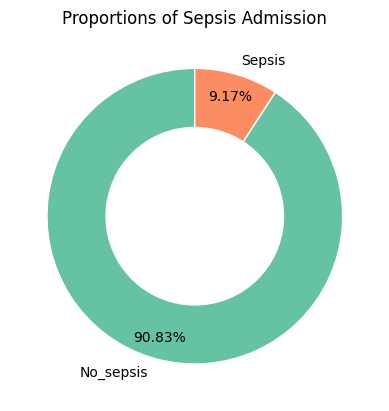

In [17]:
# Counting the number of instance in each class
label_counts = df_demographic["IS_SEPSIS"].value_counts()

# Plotting the counts in a donut chart
fig_donut, ax_donut = plt.subplots()
label_dict = {0:"No_sepsis", 1: "Sepsis"}
long_labels = df_demographic['IS_SEPSIS'].map(label_dict)
colors = sns.color_palette("Set2")
ax_donut.pie(label_counts, labels=long_labels.unique(), colors=colors,
             autopct='%1.2f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
ax_donut.set_title("Proportions of Sepsis Admission")
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig_donut.gca().add_artist(centre_circle)
plt.show()

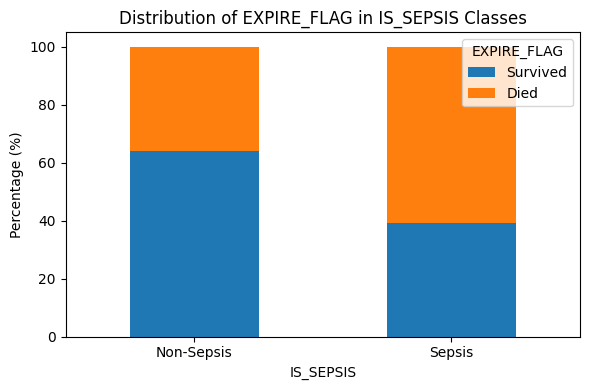

In [18]:
# Create a cross-tabulation of IS_SEPSIS and EXPIRE_FLAG
crosstab = pd.crosstab(df_demographic["IS_SEPSIS"], df_demographic["EXPIRE_FLAG"])

# Calculate the percentage distribution within each bar
crosstab_percentage = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

# Create a 100% stacked bar chart
fig, ax = plt.subplots(figsize=(6, 4))
crosstab_percentage.plot(kind="bar", stacked=True, ax=ax)

# Set labels and title
ax.set_xticklabels(['Non-Sepsis', 'Sepsis'], rotation=0)
ax.set_ylabel('Percentage (%)')
ax.set_title('Distribution of EXPIRE_FLAG in IS_SEPSIS Classes')

# Add a legend
ax.legend(title='EXPIRE_FLAG', labels=['Survived', 'Died'], loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

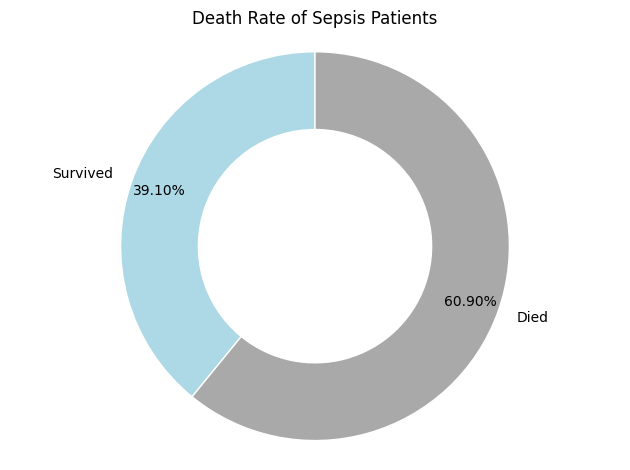

In [19]:
# Filter the DataFrame for sepsis patients (IS_SEPSIS=1) who have died (EXPIRE_FLAG=1)
sepsis_expire_counts = df_demographic[(df_demographic['IS_SEPSIS'] == 1) & (df_demographic['EXPIRE_FLAG'] == 1)]

# Count the number of instances
death_count = len(sepsis_expire_counts)

# Count the number of sepsis patients
sepsis_patient_count = len(df_demographic[df_demographic['IS_SEPSIS'] == 1])

# Calculate the survival rate
survival_rate = (sepsis_patient_count - death_count) / sepsis_patient_count
death_rate = 1 - survival_rate

# Create a figure and axis for the donut chart
fig_donut, ax_donut = plt.subplots()

# Define labels and colors for the chart
labels = ['Survived', 'Died']
colors = ['lightblue', 'darkgrey']

# Plot the counts in a donut chart
ax_donut.pie([survival_rate, death_rate], labels=labels, colors=colors,
              autopct='%1.2f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
ax_donut.set_title("Death Rate of Sepsis Patients")

# Create a white circle in the center to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig_donut.gca().add_artist(centre_circle)

# Adjust layout and show the plot
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.tight_layout()
plt.show()

### 1.2.2 Age

In [20]:
# Define bin edges to include 0 and 100
bin_edges = list(range(0, 101, 20))  # Bins every 20 years from 0 to 320 (inclusive)

# Create age bins with right=False
df_demographic['AgeGroup'] = pd.cut(df_demographic['AGE'], bins=bin_edges, labels=[f"{i}-{i+19}" for i in range(0, 100, 20)], right=False)

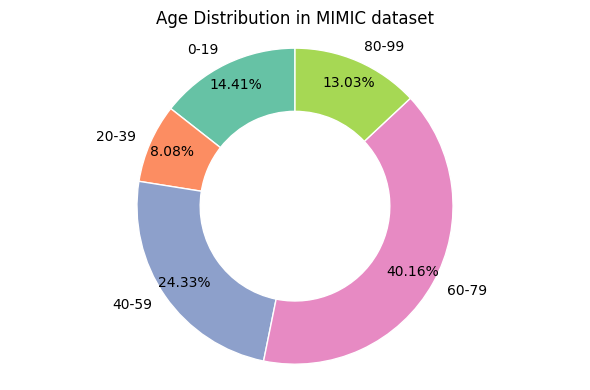

In [21]:
# Calculate the counts for each age group
age_group_counts = df_demographic['AgeGroup'].value_counts()

# Sort the age groups based on their labels
age_group_counts = age_group_counts.sort_index()

# Create a donut chart
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
colors = sns.color_palette("Set2")
plt.pie(age_group_counts.values, labels=age_group_counts.index, colors=colors, autopct='%1.2f%%', startangle=90,
        pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))

# Draw a white circle in the center to create the donut effect
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add a title
plt.title('Age Distribution in MIMIC dataset')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.tight_layout()
plt.show()

Further categorise the age groups into 7 age groups (which suspecting different sepsis pattern)

In [22]:
def categorise_age(df):
    """
    Categorise the 'AGE' column in the DataFrame into age bins.
    
    Parameters:
    - df: DataFrame containing the 'AGE' column
    
    Returns:
    - DataFrame with an additional 'AGE_cat' column containing the age categories
    """

    # define age bin edges
    age_bin_edges = [0, 1, 18, 36, 51, 71, 121]
    
    # define bin labels: neonatal, child, adult, middle-age, elderly, very old
    age_bin_labels = ['0', '1-17', '18-35', '36-50', '51-70', '71+']
    
    # create age bins
    df_demographic['AGE_cat'] = pd.cut(df_demographic['AGE'], bins=age_bin_edges, labels=age_bin_labels, right=False)
    
    return df

In [23]:
categorise_age(df_demographic)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,GENDER,DOB,EXPIRE_FLAG,AGE,IS_SEPSIS,AGE_cat,AgeGroup
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,BENZODIAZEPINE OVERDOSE,0,1,F,2131-05-07,0,64,0,51-70,60-79
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,M,2082-07-17,0,71,0,71+,60-79
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,BRAIN MASS,0,1,M,2082-07-17,0,75,0,71+,60-79
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,INTERIOR MYOCARDIAL INFARCTION,0,1,M,2100-05-31,0,39,0,36-50,20-39
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,ACUTE CORONARY SYNDROME,0,1,M,2101-11-21,0,58,0,51-70,40-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58592,98794,190603,2127-11-07 11:00:00,2127-11-11 14:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,AORTIC STENOSIS\AORTIC VALVE REPLACEMENT /SDA,0,1,M,2049-07-29,0,78,0,71+,60-79
58972,58593,98797,105447,2132-12-24 20:06:00,2132-12-25 12:00:00,2132-12-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,ALTERED MENTAL STATUS,1,1,M,2044-12-27,1,88,1,71+,80-99
58973,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,TRAUMA,0,1,F,2111-11-05,0,19,0,18-35,0-19
58974,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,SAH,1,1,F,2067-09-21,1,83,0,71+,80-99


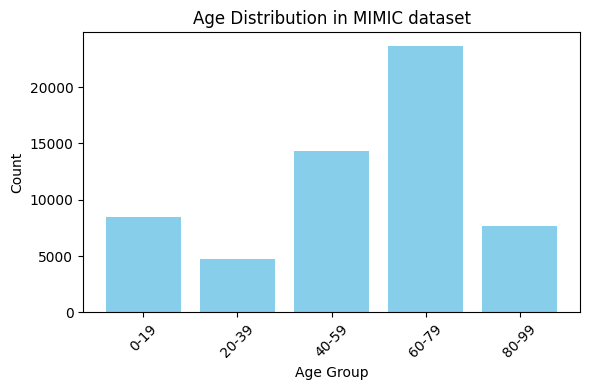

In [24]:
# Calculate the counts for each age group
age_cat_counts = df_demographic['AGE_cat'].value_counts()

# Sort the age groups based on their labels
age_cat_counts = age_cat_counts.sort_index()

# Create a bar chart
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.bar(age_group_counts.index, age_group_counts.values, color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Distribution in MIMIC dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

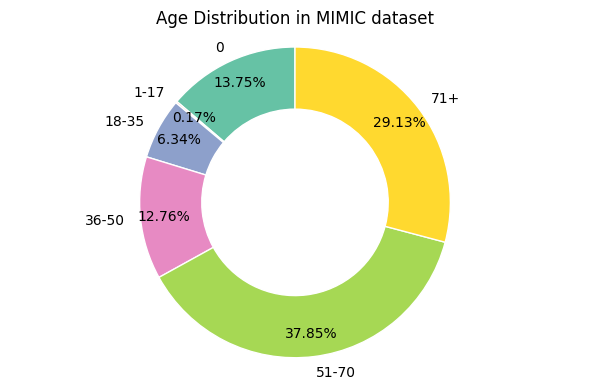

In [25]:
# Calculate the counts for each age group
age_group_counts = df_demographic['AGE_cat'].value_counts()

# Sort the age groups based on their labels
age_group_counts = age_group_counts.sort_index()

# Create a donut chart
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
colors = sns.color_palette("Set2")
plt.pie(age_group_counts.values, labels=age_group_counts.index, colors=colors, autopct='%1.2f%%', startangle=90,
        pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))

# Draw a white circle in the center to create the donut effect
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add a title
plt.title('Age Distribution in MIMIC dataset')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.tight_layout()
plt.show()

### 1.2.3 Gender

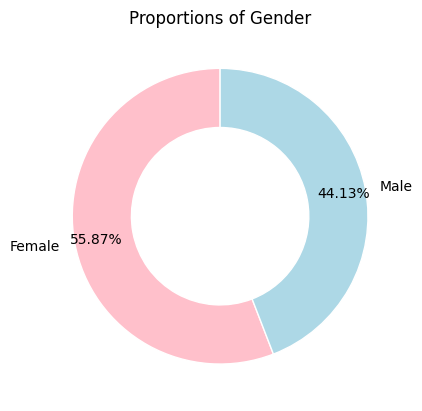

In [26]:
gender_counts = df_demographic["GENDER"].value_counts()

# Plotting the counts in a donut chart
gender_fig_donut, gender_ax_donut = plt.subplots()
gender_dict = {"M":"Male", "F": "Female"}
gender_long_labels = df_demographic['GENDER'].map(gender_dict)
gender_colors = ["pink",'lightblue']
gender_ax_donut.pie(gender_counts, labels=gender_long_labels.unique(), colors=gender_colors,
             autopct='%1.2f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
gender_ax_donut.set_title("Proportions of Gender")
centre_circle = plt.Circle((0,0),0.60,fc='white')
gender_fig_donut.gca().add_artist(centre_circle)
plt.show()

/var/folders/76/dq98d_s14kldr0y9c8hdd6tc0000gn/T/ipykernel_56095/454732794.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_gender_counts = df_demographic.groupby(['AGE_cat', 'GENDER']).size().unstack().reset_index()


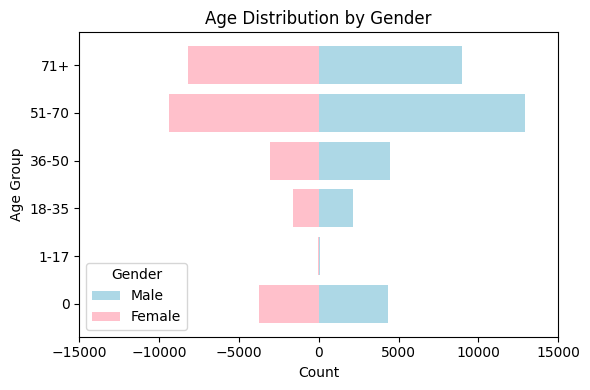

In [27]:
# Sort the DataFrame by 'AgeGroup' column
df_demographic.sort_values(by='AGE_cat', inplace=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Count the number of observations for each AgeGroup and GENDER
age_gender_counts = df_demographic.groupby(['AGE_cat', 'GENDER']).size().unstack().reset_index()

# Create side-by-side bars for males and females with opposite directions
ax.barh(age_gender_counts['AGE_cat'], age_gender_counts['M'], color="lightblue", label='Male')
ax.barh(age_gender_counts['AGE_cat'], -age_gender_counts['F'], color="pink", label='Female')

# Set labels, title, and legend
ax.set_xlabel('Count')
ax.set_ylabel('Age Group')
ax.set_title('Age Distribution by Gender')
ax.legend(title='Gender')

# Set symmetric x-axis limits
ax.set_xlim(-15000, 15000)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 1.2.4 Discharge Location

/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


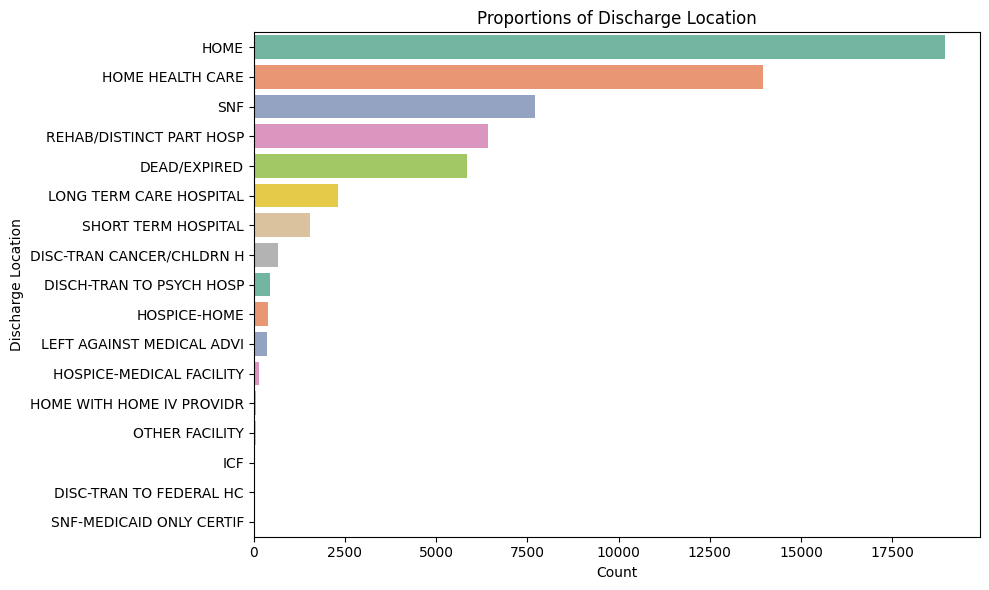

In [28]:
# Count the number of instances for each discharge location
discharge_location_counts = df_demographic["DISCHARGE_LOCATION"].value_counts()

# Create a figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for the chart
colors = sns.color_palette("Set2")

# Create a bar chart for discharge locations
sns.barplot(x=discharge_location_counts.values, y=discharge_location_counts.index, palette=colors, ax=ax)

# Set labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Discharge Location')
ax.set_title('Proportions of Discharge Location')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Estimating labevents time interval

In [67]:
# Read LABEVENTS.csv and filter rows where HADM_ID is missing

# Read ADMISSIONS.csv
df_empty_hadm_labevents = df_labevents[df_labevents['HADM_ID'].isnull()]
df_filled_hadm_labevents = df_labevents[pd.to_numeric(df_labevents["HADM_ID"], errors='coerce').notnull()]

df_admissions.sort_values(by=["SUBJECT_ID", "ADMITTIME"], inplace=True)
df_empty_hadm_labevents.sort_values(by=["SUBJECT_ID", "CHARTTIME"], inplace=True)

# Sorting both DataFrames by the keys used for merging

df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'])
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'])
df_empty_hadm_labevents['CHARTTIME'] = pd.to_datetime(df_empty_hadm_labevents['CHARTTIME']) 

# Merge and fill missing HADM_ID using inner join
merged_data = df_empty_hadm_labevents.merge(df_admissions, on='SUBJECT_ID', how='inner')
mask = (merged_data['CHARTTIME'] >= merged_data['ADMITTIME']) & (merged_data['CHARTTIME'] <= merged_data['DISCHTIME'])
#Main Task
#if charttime falls between admission time and discharge time then replace labevents hadm_id with admissions table

#to show all the rows
merged_data.loc[mask, 'HADM_ID_x'] = merged_data.loc[mask, 'HADM_ID_y']

# Rename the column back to 'HADM_ID'
merged_data.rename(columns={'HADM_ID_x': 'HADM_ID'}, inplace=True)

# Drop unnecessary columns
merged_data.sort_values(by=["ROW_ID_x"], inplace=True)
merged_data.drop(['HADM_ID_y', 'ROW_ID_y'], axis=1, inplace=True)
merged_data.rename(columns={'SUBJECT_ID_y': 'ADMISSION_SUBJECT_ID'}, inplace=True)

filtered_data_hasHADM = merged_data[merged_data['HADM_ID'].notna()].drop_duplicates(subset=['ROW_ID_x']) #NEED TO CHECK IF unnecessary rows are present since we used merge with adissions and lab events before
filtered_data_noHADM = merged_data[merged_data['HADM_ID'].isnull()].drop_duplicates(subset=['ROW_ID_x'])
filtered_data_hasHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)
filtered_data_noHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)

row_ids_in_hasHADM = set(filtered_data_hasHADM['ROW_ID'])
filtered_data_noHADM = filtered_data_noHADM[~filtered_data_noHADM['ROW_ID'].isin(row_ids_in_hasHADM)] #Had to refilter filtered_data_noHADM since there were unnecessary rows

columns_to_remove = ['ADMITTIME','DISCHTIME','DEATHTIME', 'ADMISSION_TYPE',  'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE',    'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',   'ETHNICITY', 'EDREGTIME'    ,'EDOUTTIME'    ,'DIAGNOSIS'    ,'HOSPITAL_EXPIRE_FLAG' ,'HAS_CHARTEVENTS_DATA']

# Drop the specified columns
filtered_data_noHADM = filtered_data_noHADM.drop(columns=columns_to_remove)
filtered_data_hasHADM = filtered_data_hasHADM.drop(columns=columns_to_remove)

# filtered_data_hasHADM.to_csv('filtered_data_hasHADM.csv', index=False)
# filtered_data_noHADM.to_csv('filtered_data_noHADM.csv', index=False)

#Uncomment these if you want to export to CSV
# filtered_data_hasHADM.to_csv('filtered_data_hasHADM.csv', index=False)
# filtered_data_noHADM.to_csv('filtered_data_noHADM.csv', index=False)

/var/folders/76/dq98d_s14kldr0y9c8hdd6tc0000gn/T/ipykernel_56095/1800811570.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_empty_hadm_labevents.sort_values(by=["SUBJECT_ID", "CHARTTIME"], inplace=True)
/var/folders/76/dq98d_s14kldr0y9c8hdd6tc0000gn/T/ipykernel_56095/1800811570.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_empty_hadm_labevents['CHARTTIME'] = pd.to_datetime(df_empty_hadm_labevents['CHARTTIME'])


In [68]:
# FINAL these three together is the total lab_events len(df_filled_hadm_labevents) + len(filtered_data_hasHADM) + len(filtered_data_noHADM)

combined_df_hasHADM = pd.concat([df_filled_hadm_labevents, filtered_data_hasHADM], ignore_index=True)
combined_df_hasHADM['HADM_ID'] = combined_df_hasHADM['HADM_ID'].astype(int)
combined_df_hasHADM

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,441,3,145834,50868,2101-10-20 16:40:00,17,17.00,mEq/L,NaN
1,442,3,145834,50882,2101-10-20 16:40:00,25,25.00,mEq/L,NaN
2,443,3,145834,50893,2101-10-20 16:40:00,8.2,8.20,mg/dL,abnormal
3,444,3,145834,50902,2101-10-20 16:40:00,99,99.00,mEq/L,abnormal
4,445,3,145834,50910,2101-10-20 16:40:00,48,48.00,IU/L,NaN
...,...,...,...,...,...,...,...,...,...
22264045,27606711,97845,199408,50960,2183-12-26 05:55:00,1.9,1.90,mg/dL,NaN
22264046,27606712,97845,199408,50970,2183-12-26 05:55:00,2.1,2.10,mg/dL,abnormal
22264047,27606713,97845,199408,50971,2183-12-26 05:55:00,3.0,3.00,mEq/L,abnormal
22264048,27606714,97845,199408,50983,2183-12-26 05:55:00,139,139.00,mEq/L,NaN


In [69]:
# Removing rows with missing HADM_ID
df_labevents_clean1 = combined_df_hasHADM
df_labevents_clean1.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,441,3,145834,50868,2101-10-20 16:40:00,17,17.00,mEq/L,NaN
1,442,3,145834,50882,2101-10-20 16:40:00,25,25.00,mEq/L,NaN
2,443,3,145834,50893,2101-10-20 16:40:00,8.2,8.20,mg/dL,abnormal
3,444,3,145834,50902,2101-10-20 16:40:00,99,99.00,mEq/L,abnormal
4,445,3,145834,50910,2101-10-20 16:40:00,48,48.00,IU/L,NaN
5,446,3,145834,50911,2101-10-20 16:40:00,NotDone,NaN,ng/mL,NaN
6,447,3,145834,50912,2101-10-20 16:40:00,3.2,3.20,mg/dL,abnormal
7,448,3,145834,50931,2101-10-20 16:40:00,91,91.00,mg/dL,NaN
8,449,3,145834,50960,2101-10-20 16:40:00,2.4,2.40,mg/dL,NaN
9,450,3,145834,50970,2101-10-20 16:40:00,4.8,4.80,mg/dL,abnormal


In [74]:
# Merge LABEVENTS with ADMISSIONS on SUBJECT_ID and HADM_ID
combined_df = df_labevents_clean1.merge(df_admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']], 
                               on=['SUBJECT_ID', 'HADM_ID'], 
                               how='left')

combined_df.head(-10)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,ADMITTIME,DISCHTIME
0,441,3,145834,50868,2101-10-20 16:40:00,17,17.00,mEq/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00
1,442,3,145834,50882,2101-10-20 16:40:00,25,25.00,mEq/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00
2,443,3,145834,50893,2101-10-20 16:40:00,8.2,8.20,mg/dL,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00
3,444,3,145834,50902,2101-10-20 16:40:00,99,99.00,mEq/L,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00
4,445,3,145834,50910,2101-10-20 16:40:00,48,48.00,IU/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00
...,...,...,...,...,...,...,...,...,...,...,...
22264035,27606701,97845,199408,51265,2183-12-25 06:10:00,121,121.00,K/uL,abnormal,2183-12-23 18:38:00,2183-12-26 17:54:00
22264036,27606702,97845,199408,51277,2183-12-25 06:10:00,12.9,12.90,%,NaN,2183-12-23 18:38:00,2183-12-26 17:54:00
22264037,27606703,97845,199408,51279,2183-12-25 06:10:00,4.09,4.09,m/uL,abnormal,2183-12-23 18:38:00,2183-12-26 17:54:00
22264038,27606704,97845,199408,51301,2183-12-25 06:10:00,8.7,8.70,K/uL,delta,2183-12-23 18:38:00,2183-12-26 17:54:00


In [75]:
# Compute STAY_DURATION as CHARTTIME - ADMITTIME
combined_df['STAY_DURATION'] = (combined_df['CHARTTIME'] - combined_df['ADMITTIME']).dt.total_seconds() / 3600  # duration in hours

# Compute BEFORE_DISCHARGE as DISCHTIME - CHARTTIME
combined_df['BEFORE_DISCHARGE'] = (combined_df['CHARTTIME'] - combined_df['DISCHTIME']).dt.total_seconds() / 3600  # duration in hours

# Compute TOTAL_STAY as DISCHTIME - ADMITTIME
combined_df['TOTAL_STAY'] = (combined_df['DISCHTIME'] - combined_df['ADMITTIME']).dt.total_seconds() / 3600  # duration in hours

combined_df.head(-10)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,ADMITTIME,DISCHTIME,STAY_DURATION,BEFORE_DISCHARGE,TOTAL_STAY
0,441,3,145834,50868,2101-10-20 16:40:00,17,17.00,mEq/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,-2.47,-261.30,258.83
1,442,3,145834,50882,2101-10-20 16:40:00,25,25.00,mEq/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,-2.47,-261.30,258.83
2,443,3,145834,50893,2101-10-20 16:40:00,8.2,8.20,mg/dL,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,-2.47,-261.30,258.83
3,444,3,145834,50902,2101-10-20 16:40:00,99,99.00,mEq/L,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,-2.47,-261.30,258.83
4,445,3,145834,50910,2101-10-20 16:40:00,48,48.00,IU/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,-2.47,-261.30,258.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22264035,27606701,97845,199408,51265,2183-12-25 06:10:00,121,121.00,K/uL,abnormal,2183-12-23 18:38:00,2183-12-26 17:54:00,35.53,-35.73,71.27
22264036,27606702,97845,199408,51277,2183-12-25 06:10:00,12.9,12.90,%,NaN,2183-12-23 18:38:00,2183-12-26 17:54:00,35.53,-35.73,71.27
22264037,27606703,97845,199408,51279,2183-12-25 06:10:00,4.09,4.09,m/uL,abnormal,2183-12-23 18:38:00,2183-12-26 17:54:00,35.53,-35.73,71.27
22264038,27606704,97845,199408,51301,2183-12-25 06:10:00,8.7,8.70,K/uL,delta,2183-12-23 18:38:00,2183-12-26 17:54:00,35.53,-35.73,71.27


: 

In [45]:
# Replace all negative STAY_DURATION to 0
combined_df['STAY_DURATION'] = combined_df['STAY_DURATION'].where(combined_df['STAY_DURATION'] >= 0, 0)
# Round off to 1 d.p.
combined_df['STAY_DURATION'] = combined_df['STAY_DURATION'].round(0)
combined_df['BEFORE_DISCHARGE'] = combined_df['BEFORE_DISCHARGE'].round(0)
combined_df['TOTAL_STAY'] = combined_df['TOTAL_STAY'].round(0)

combined_df.head(-10)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,ADMITTIME,DISCHTIME,STAY_DURATION,BEFORE_DISCHARGE,TOTAL_STAY
0,441,3,145834,50868,2101-10-20 16:40:00,17,17.00,mEq/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0.00,-261.00,259.00
1,442,3,145834,50882,2101-10-20 16:40:00,25,25.00,mEq/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0.00,-261.00,259.00
2,443,3,145834,50893,2101-10-20 16:40:00,8.2,8.20,mg/dL,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0.00,-261.00,259.00
3,444,3,145834,50902,2101-10-20 16:40:00,99,99.00,mEq/L,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0.00,-261.00,259.00
4,445,3,145834,50910,2101-10-20 16:40:00,48,48.00,IU/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0.00,-261.00,259.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22245019,27428425,96443,103219,50818,2109-12-29 23:04:00,49,49.00,mm Hg,abnormal,2109-12-20 07:15:00,2110-01-05 16:00:00,232.00,-161.00,393.00
22245020,27428426,96443,103219,50820,2109-12-29 23:04:00,7.37,7.37,units,NaN,2109-12-20 07:15:00,2110-01-05 16:00:00,232.00,-161.00,393.00
22245021,27428427,96443,103219,50821,2109-12-29 23:04:00,88,88.00,mm Hg,NaN,2109-12-20 07:15:00,2110-01-05 16:00:00,232.00,-161.00,393.00
22245022,27428428,96443,103219,50825,2109-12-29 23:04:00,38.3,38.30,NaN,NaN,2109-12-20 07:15:00,2110-01-05 16:00:00,232.00,-161.00,393.00


In [46]:
selected_columns = ['STAY_DURATION', 'BEFORE_DISCHARGE', 'TOTAL_STAY']  # You can add or replace with columns of your choice
pd.set_option('display.float_format', '{:.2f}'.format)
combined_df[selected_columns].describe()

,STAY_DURATION,BEFORE_DISCHARGE,TOTAL_STAY
count,22245034.00,22245034.00,22245034.00
mean,204.47,-318.61,522.81
std,327.32,401.09,566.01
min,0.00,-7068.00,-23.00
25%,23.00,-390.00,184.00
50%,96.00,-192.00,346.00
75%,252.00,-97.00,656.00
max,7064.00,1245.00,7072.00


In [47]:
combined_df[combined_df['STAY_DURATION'] >= 7063]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,ADMITTIME,DISCHTIME,STAY_DURATION,BEFORE_DISCHARGE,TOTAL_STAY
5932550,7865727,12613,168201,50800,2136-10-17 05:33:00,ART,NaN,NaN,NaN,2135-12-27 21:39:00,2136-10-17 13:30:00,7064.00,-8.00,7072.00
5932551,7865728,12613,168201,50802,2136-10-17 05:33:00,6,6.00,mEq/L,NaN,2135-12-27 21:39:00,2136-10-17 13:30:00,7064.00,-8.00,7072.00
5932552,7865729,12613,168201,50804,2136-10-17 05:33:00,34,34.00,mEq/L,abnormal,2135-12-27 21:39:00,2136-10-17 13:30:00,7064.00,-8.00,7072.00
5932553,7865730,12613,168201,50818,2136-10-17 05:33:00,56,56.00,mm Hg,abnormal,2135-12-27 21:39:00,2136-10-17 13:30:00,7064.00,-8.00,7072.00
5932554,7865731,12613,168201,50820,2136-10-17 05:33:00,7.38,7.38,units,NaN,2135-12-27 21:39:00,2136-10-17 13:30:00,7064.00,-8.00,7072.00
5932555,7865732,12613,168201,50821,2136-10-17 05:33:00,111,111.00,mm Hg,abnormal,2135-12-27 21:39:00,2136-10-17 13:30:00,7064.00,-8.00,7072.00


In [54]:
# Group by STAY_DURATION and count the lab events
grouped = combined_df.groupby('STAY_DURATION').size().reset_index(name='counts')

# Optionally, if you want to ensure every hour from 1 to 24 is represented, you can do the following:
all_hours = pd.DataFrame({'STAY_DURATION': [i for i in range(1, 25)]})
grouped = all_hours.merge(grouped, on='STAY_DURATION', how='left').fillna(0)

print(grouped)

    STAY_DURATION  counts
0               1  310635
1               2  291887
2               3  250111
3               4  237042
4               5  205094
5               6  202770
6               7  181282
7               8  179196
8               9  167066
9              10  166502
10             11  150370
11             12  146654
12             13  134752
13             14  131357
14             15  121828
15             16  121513
16             17  108418
17             18  121088
18             19  118519
19             20  115887
20             21  103620
21             22  103201
22             23  100372
23             24   99139


/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amyhung/Documents/CITS5553

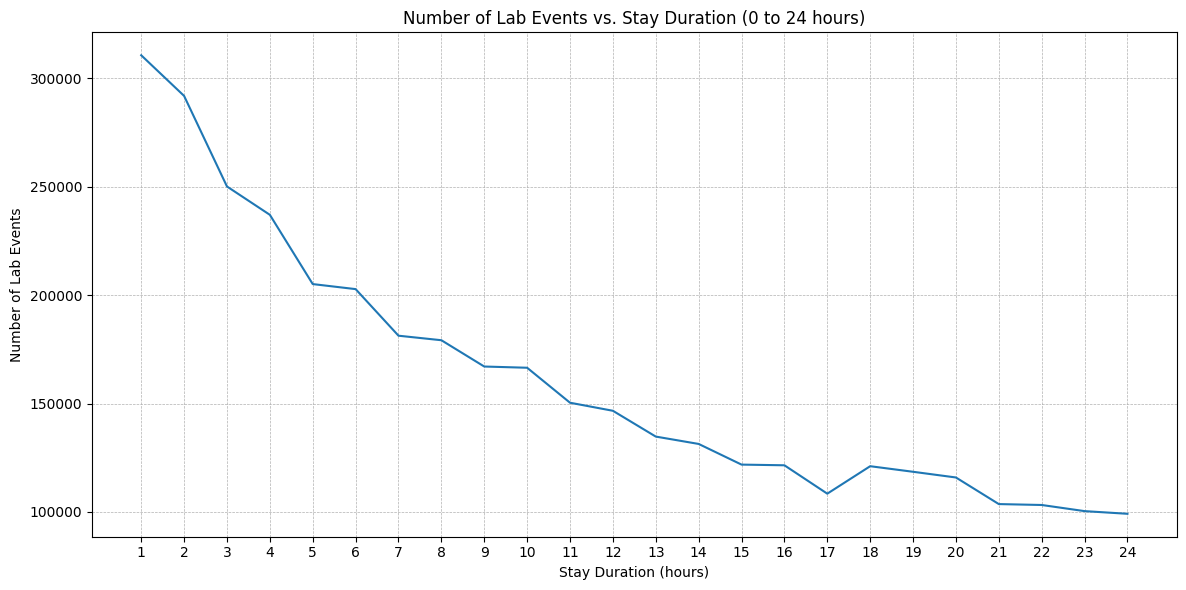

In [52]:
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='STAY_DURATION', y='counts', data=grouped)

plt.title('Number of Lab Events vs. Stay Duration (0 to 24 hours)')
plt.xlabel('Stay Duration (hours)')
plt.ylabel('Number of Lab Events')
plt.tight_layout()
plt.xticks(range(1, 25))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/d

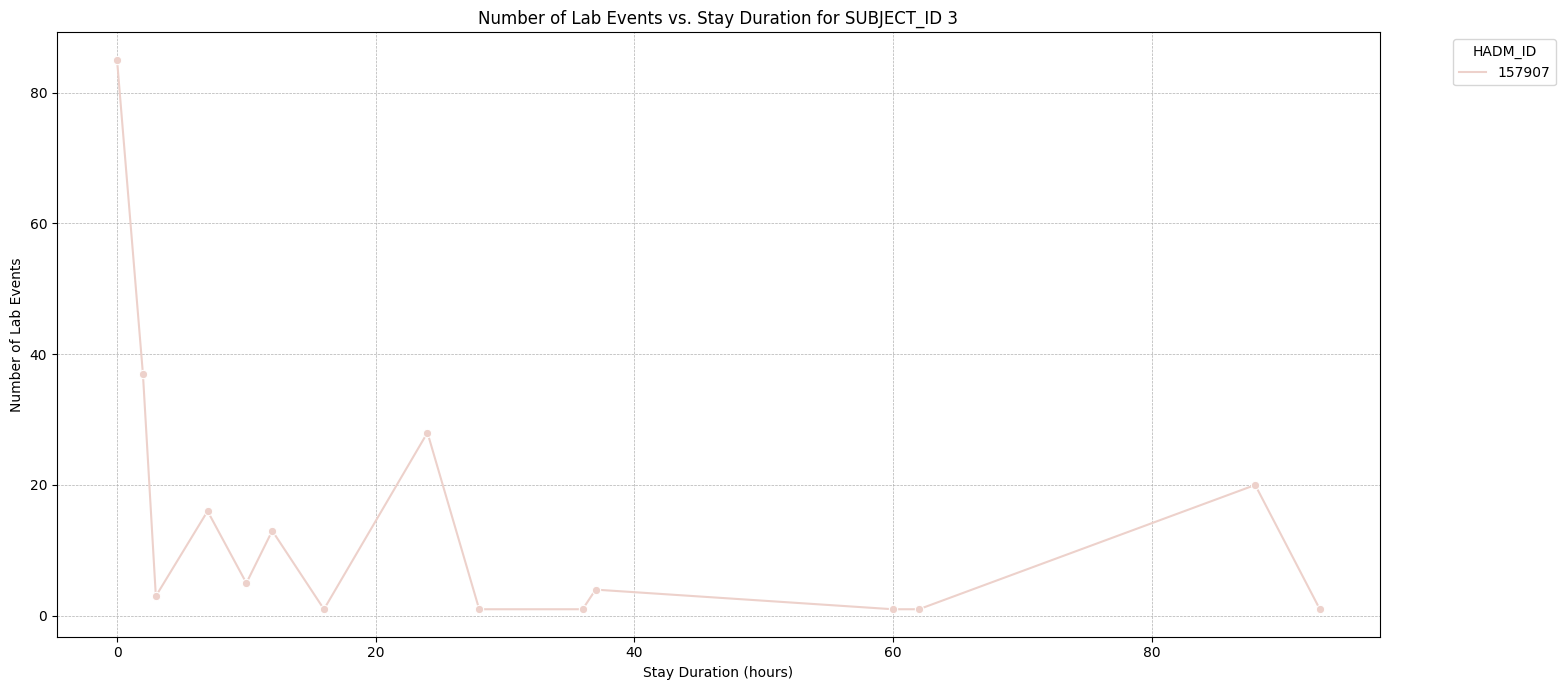

In [66]:
# Filter dataset for a specific SUBJECT_ID
subject_data = combined_df[combined_df['SUBJECT_ID'] == 45]
grouped_subject_data = subject_data.groupby(['HADM_ID', 'STAY_DURATION']).size().reset_index(name='counts')

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x='STAY_DURATION', y='counts', hue='HADM_ID', data=grouped_subject_data, marker='o')

plt.title('Number of Lab Events vs. Stay Duration for SUBJECT_ID 3')
plt.xlabel('Stay Duration (hours)')
plt.ylabel('Number of Lab Events')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend(title='HADM_ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.show()

## 1.3 Feature Selection

# 2.Sepsis Risk Predicting Model Implementation

## 2.1 Logistics Regression Model

## 2.2 Random Forest Model

## 2.3 Gradient Boosted Model

## 2.4 LSTM Model

## 2.5 LSTM + Attention Model

# 3.Clustering Model

# 4.Model Testing

# 5.Local and Global Feature Explanation